In [1]:
import os
import argparse
import tempfile
import json
import numpy as np
import pandas as pd
from google.cloud import bigquery, storage
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support
import xgboost as xgb
# import mlflow
# import mlflow.xgboost
import joblib
import logging

## Loading Transformed & Engineered Features Data from the BigQuery Warehouse

In [3]:
from google.cloud import bigquery
import pandas as pd

# Initialize BigQuery client (assumes your notebook is authenticated)
client = bigquery.Client()

# Define your project and table details
PROJECT_ID = "olist-ecommerce-dw"  # Replace with your Project ID
DATASET_ID = "gold"
TABLE_ID = "agg_ltv_features" # Your final table name

# Query to select all data from the training table
QUERY = f"""
    SELECT *
    FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
      -- Exclude rows where features are null due to insufficient lookback (optional but safe)
"""

# Run the query and load the result into a Pandas DataFrame
df = client.query(QUERY).to_dataframe()

print(f"Loaded {len(df)} rows for training.")
df.head()

Loaded 2044 rows for training.


,seller_id,total_orders,total_spent,avg_order_value,recency_days,days_since_first_purchase,customer_tenure_days,avg_delivery_delay,pct_ontime_deliveries,avg_early_deliver_days,...,credit_pay_rate,avg_payment_installments,payment_match_rate,unique_products_bought,unique_categories_bought,avg_product_price,avg_freight_value,last_purchase_month,pct_orders_peak_season,ltv_6m
0,b86a47b3366e3b5424a7b225781f4908,1,106.35,106.35,102,102,0,14.0,1.0,13.33,...,1.0,1.0,1.0,1,0,87.0,20.0,1,0.0,0.0
1,7a704e63bb29c446869efde5d57524c8,1,109.90,109.90,82,82,0,19.0,1.0,18.92,...,1.0,2.0,1.0,1,1,94.0,15.0,1,0.0,0.0
2,c74f14c1e26cf1bd5bd34b6a1e274426,1,55.79,55.79,80,80,0,26.0,1.0,26.00,...,1.0,1.0,1.0,1,1,39.0,17.0,1,0.0,0.0
3,2ef086a599b597572aca4433b7ed6b3d,1,64.10,64.10,96,96,0,15.0,1.0,14.46,...,1.0,6.0,1.0,1,1,49.0,15.0,1,0.0,0.0
4,417a1e6c7321084d2a0ae0d023cfad93,1,61.38,61.38,76,76,0,17.0,1.0,16.46,...,1.0,1.0,1.0,1,1,49.0,12.0,1,0.0,0.0


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df.describe()

,total_orders,total_spent,avg_order_value,recency_days,days_since_first_purchase,customer_tenure_days,avg_delivery_delay,pct_ontime_deliveries,avg_early_deliver_days,avg_shipping_duration,...,credit_pay_rate,avg_payment_installments,payment_match_rate,unique_products_bought,unique_categories_bought,avg_product_price,avg_freight_value,last_purchase_month,pct_orders_peak_season,ltv_6m
count,2044.0,2.044000e+03,2044.000000,2044.0,2044.0,2044.0,2044.000000,2044.000000,2044.000000,2044.000000,...,2044.0,2044.000000,2044.0,2044.0,2044.0,2044.000000,2044.000000,2044.0,2044.000000,2044.000000
mean,50.359589,1.295435e+04,256.601795,74.802838,215.92319,141.120352,10.838596,0.896468,10.157965,13.895225,...,1.0,3.324843,1.0,11.696673,2.151174,173.541585,22.842955,4.84002,0.179130,2395.584462
std,156.416604,6.337561e+04,448.134213,96.157568,118.700887,125.012881,7.006901,0.199111,7.007255,6.894324,...,0.0,2.105066,0.0,24.459862,2.193557,304.168713,18.769444,2.949957,0.254424,7780.651343
min,1.0,2.400000e+01,13.630000,0.0,0.0,0.0,-58.000000,0.000000,-58.580000,1.000000,...,1.0,1.000000,1.0,1.0,0.0,3.000000,3.000000,1.0,0.000000,0.000000
25%,3.0,4.202250e+02,94.770000,5.0,119.75,15.75,8.200000,0.890000,7.530000,10.000000,...,1.0,1.887500,1.0,2.0,1.0,52.000000,15.000000,3.0,0.000000,0.000000
50%,10.0,1.898065e+03,153.970000,26.0,224.0,118.5,11.260000,0.980000,10.600000,12.825000,...,1.0,2.920000,1.0,4.0,1.0,94.000000,18.000000,4.0,0.071429,276.575000
75%,38.0,7.949670e+03,264.697500,123.0,337.0,249.0,14.382500,1.000000,13.690000,16.000000,...,1.0,4.160000,1.0,11.0,2.0,172.000000,23.000000,5.0,0.261059,1799.947500
max,3032.0,1.651019e+06,12871.370000,365.0,365.0,365.0,52.380000,1.000000,51.730000,86.000000,...,1.0,15.170000,1.0,414.0,25.0,6499.000000,228.000000,12.0,1.000000,143225.790000


In [9]:
df["churn_6m"] = df["ltv_6m"].apply(lambda x: 0 if x>0 else 1)
df["churn_6m"].value_counts(normalize=True)

churn_6m
0    0.603229
1    0.396771
Name: proportion, dtype: float64

## Retrieve the Classification Result of Random Forest Classifier

In [10]:
import joblib
file_name = 'random_forest_model.joblib'
churn_model = joblib.load(file_name)

In [13]:
selected_feas = ['recency_days', 'last_purchase_month', 'days_since_first_purchase', 'total_orders', 'review_count']
X_churn = df[selected_feas] 
y_churn_pred = churn_model.predict(X_churn)
df["churn_6m_pred"] = y_churn_pred

* After applying the churn model on the whole data; False Negative, False Positive and True Negative will be taken for LTV prediction.
* By using True Negative, the predicted loyal customers will provide lifetime value ground truth for training & prediction.
* In parallel, taking the False Positive will make the LTV model the ability of adapting and correcting the wrong detection of the previous classification model.
* This will be filtered using recordings that is not True Positive, which results in 1383 predicted non-churn sellers.

In [35]:
df_ltv = df[~((df["churn_6m"]==1) & (df["churn_6m_pred"]==1))]
df_ltv.describe()

,total_orders,total_spent,avg_order_value,recency_days,days_since_first_purchase,customer_tenure_days,avg_delivery_delay,pct_ontime_deliveries,avg_early_deliver_days,avg_shipping_duration,...,unique_products_bought,unique_categories_bought,avg_product_price,avg_freight_value,last_purchase_month,pct_orders_peak_season,ltv_6m,churn_6m,churn_pred,churn_6m_pred
count,1383.0,1.383000e+03,1383.000000,1383.0,1383.0,1383.0,1383.000000,1383.000000,1383.000000,1383.000000,...,1383.0,1383.0,1383.000000,1383.000000,1383.0,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000
mean,69.036876,1.771638e+04,253.887744,23.543022,199.441793,175.898771,10.697802,0.896717,10.010723,13.693919,...,15.506869,2.517715,163.304411,22.503977,3.840202,0.166824,3540.545654,0.108460,0.109906,0.109906
std,186.586275,7.616837e+04,438.896401,39.256653,124.453547,127.220838,6.262447,0.170044,6.258366,5.824129,...,28.772143,2.477294,236.908127,17.441316,1.661186,0.201071,9243.210036,0.311073,0.312886,0.312886
min,1.0,2.505000e+01,13.630000,0.0,0.0,0.0,-58.000000,0.000000,-58.580000,2.000000,...,1.0,0.0,3.000000,3.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.0,8.248750e+02,102.340000,2.0,84.5,54.0,8.230000,0.870000,7.560000,10.200000,...,2.5,1.0,55.000000,15.000000,3.0,0.000000,254.010000,0.000000,0.000000,0.000000
50%,18.0,3.409010e+03,161.930000,9.0,196.0,174.0,10.880000,0.950000,10.190000,13.000000,...,6.0,2.0,96.000000,18.000000,4.0,0.116279,996.250000,0.000000,0.000000,0.000000
75%,58.5,1.143867e+04,265.150000,27.0,334.0,303.5,13.880000,1.000000,13.130000,15.855000,...,16.0,3.0,170.000000,23.000000,4.0,0.259347,3010.430000,0.000000,0.000000,0.000000
max,3032.0,1.651019e+06,12871.370000,347.0,365.0,365.0,52.380000,1.000000,51.730000,68.000000,...,414.0,25.0,3133.000000,213.000000,12.0,1.000000,143225.790000,1.000000,1.000000,1.000000


## Training Preparation

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
df.columns

Index(['seller_id', 'total_orders', 'total_spent', 'avg_order_value',
       'recency_days', 'days_since_first_purchase', 'customer_tenure_days',
       'avg_delivery_delay', 'pct_ontime_deliveries', 'avg_early_deliver_days',
       'avg_shipping_duration', 'avg_review_score', 'review_count',
       'pct_positive_reviews', 'avg_response_time', 'credit_pay_rate',
       'avg_payment_installments', 'payment_match_rate',
       'unique_products_bought', 'unique_categories_bought',
       'avg_product_price', 'avg_freight_value', 'last_purchase_month',
       'pct_orders_peak_season', 'ltv_6m', 'churn_6m', 'churn_pred',
       'churn_6m_pred'],
      dtype='object')

In [38]:
features = [
   'total_orders', 'total_spent', 'avg_order_value',
   'recency_days', 'days_since_first_purchase', 'customer_tenure_days',
   'avg_delivery_delay', 'pct_ontime_deliveries', 'avg_early_deliver_days',
   'avg_shipping_duration', 'avg_review_score', 'review_count',
   'pct_positive_reviews', 'avg_response_time', 'credit_pay_rate',
   'avg_payment_installments', 'payment_match_rate',
   'unique_products_bought', 'unique_categories_bought',
   'avg_product_price', 'avg_freight_value', 'last_purchase_month',
   'pct_orders_peak_season'
]
target = 'ltv_6m'

X = df_ltv[features]
y = df_ltv[target].values

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=6199)

## Model Baseline Testing & Training

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [43]:
model_dict = {
    # "LinearRegression": LinearRegression(),
    "Random Forest" : RandomForestRegressor(n_estimators= 100, max_depth=5, random_state=6199),
    "XGBoost" : xgb.XGBRegressor(
        objective='reg:squarederror', # Objective loss function
        n_estimators=100,             # Number of boosting rounds
        learning_rate=0.1,            # Step size shrinkage
        max_depth=5,                  # Tree depth
        random_state=6199,
        n_jobs=-1
    )
}

In [45]:
def model_train_metrics(model_dict, X_train, X_test, y_train, y_test, features):
    eval_score = {}
    features_ipt = {}
    trained_model = {}
    for name, model in model_dict.items():
        # Train & Predict label & probability classes (using a standard 0.5 threshold)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Save metrics & confusion metrics in dictionary for later evaluation
        eval_score[name] = [mse, rmse, r2]
        features_ipt[name] = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False).rename("importance_score").reset_index()
        trained_model[name] = model
    return eval_score, trained_model, features_ipt
eval_score, trained_model, features_ipt = model_train_metrics(model_dict, X_train, X_test, y_train, y_test, features)

## Model Evaluation

In [34]:
df_eval_score = pd.DataFrame(eval_score, index = ["MSE", "RMSE", "R2"]).transpose()
df_eval_score

,MSE,RMSE,R2
LinearRegression,7.052726e+07,8398.051171,0.456707
Random Forest,6.306586e+07,7941.401459,0.514184
XGBoost,9.224624e+07,9604.490375,0.289399


In [46]:
df_ipt = pd.merge(left=features_ipt["Random Forest"], right=features_ipt["XGBoost"], on="index")
df_ipt = df_ipt.rename(columns=dict(zip(df_ipt.columns, ["Features", "Random Forest", "XGBoost"])))
df_ipt = df_ipt.sort_values(by="Random Forest", ascending=False)

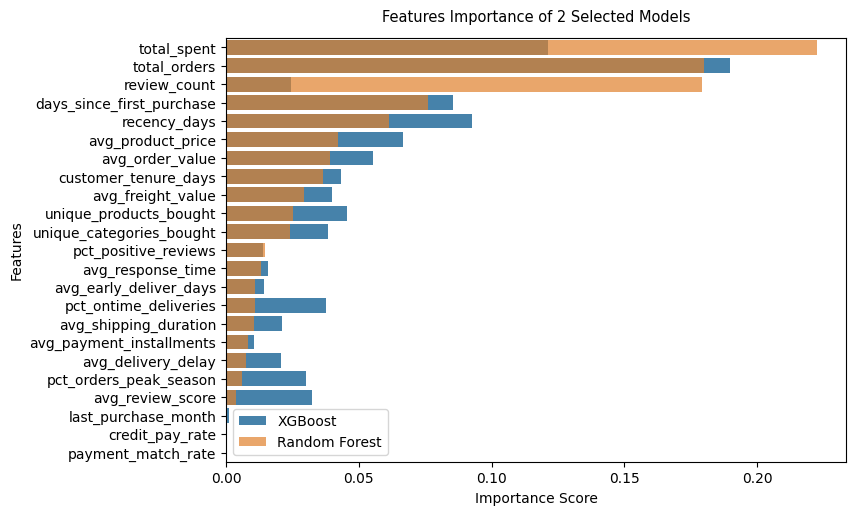

In [51]:
plt.figure(figsize=(8,5.5))
sns.barplot(data=df_ipt, y="Features", x="XGBoost", color="#1F77B4", alpha=0.9, label="XGBoost")
sns.barplot(data=df_ipt, y="Features", x="Random Forest", color="#FF7F0E", alpha=0.7, label="Random Forest")
plt.title("Features Importance of 2 Selected Models", fontsize=10.5, y=1.02)
plt.xlabel("Importance Score")
plt.show()

In [48]:
selected_feas = df_ipt.nlargest(6, 'Random Forest')["Features"].values
selected_feas

array(['total_spent', 'total_orders', 'review_count',
       'days_since_first_purchase', 'recency_days', 'avg_product_price'],
      dtype=object)

In [49]:
X_fi = df[selected_feas]
y_fi = df[target].values
X_train_fi, X_test_fi, y_train_fi, y_test_fi = train_test_split(X_fi, y_fi, test_size=0.25, random_state=6199)
eval_score_fi, features_ipt_fi, trained_model_fi = model_train_metrics(model_dict=model_dict, X_train=X_train_fi, X_test=X_test_fi, y_train=y_train_fi, y_test=y_test_fi, features=selected_feas)

In [52]:
df_eval_score = pd.DataFrame(eval_score_fi, index = ["MSE", "RMSE", "R2"]).transpose()
df_eval_score

,MSE,RMSE,R2
Random Forest,3.546158e+07,5954.962506,0.482524
XGBoost,3.077898e+07,5547.880812,0.550855
